# Linear decay chains and the Bateman equation
This [jupyter notebook](http://www.jupyter.org) aims to show how one may interactively work with [SymPy](http://www.sympy.org) to get help with integrating differential equations, checking correctness of solutions and generating numerical solutions with arbitrary precision. All of which is really handy when equations get complicated.

Consider the following decay chain

$$ u \overset{k}{\rightarrow} v \overset{l}{\rightarrow} w \overset{m}{\rightarrow} x $$

we will use SymPy to "manually" solve the system of diffential equations describing the time evolution of the amounts (concentrations) of respective species.

In [1]:
from IPython.display import display
from sympy.interactive import printing
printing.init_printing()

import sympy
from sympy import S, symbols, Function, Symbol, Eq, exp, Integral, refine, lambdify, latex
print(sympy.__version__)

1.0.1.dev


Let us define the variables, $t$ is time.

In [2]:
params = k, l, m = symbols('k l m'.split(), positive=True)
params.append(S('0'))  # x does not decay, S('0') gives us a "SymPy zero"
t = Symbol('t')
funcs = u, v, w, x = [Function(s)(t) for s in 'uvwx']
inits = u0, v0, w0, x0 = symbols('u0 v0 w0 x0'.split())  # initial values at t=0
display(params, t, funcs, inits)

Let us define our governing equations as ``eqs``

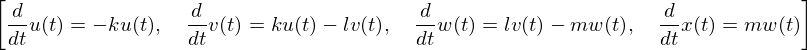

In [3]:
eqs = [Eq(u.diff(t), -k*u), Eq(v.diff(t), k*u - l*v), Eq(w.diff(t), l*v - m*w), Eq(x.diff(t), m*w)]
eqs

We will need som integration constants, let us call them ``C``. We also create a list called ``sol`` to collect our analytic solutions as we go along

In [4]:
C = symbols('C:4')  # create C0, C1, C2, C3
solutions = [S('0')]*4  # sol is length 4 list of zeroes

Let's focus on the first equation and try an ansatz for $u(t)$

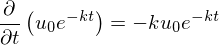

In [5]:
solutions[0] = inits[0]*exp(-k*t)  # our guess
eqs[0].subs({funcs[0]: solutions[0]})  # substitute our functions "u(t)" with our "u0*exp(-k*t)"

In [6]:
# Last cells result is saved in the variable "_", let's evaluate that Equality
_.doit()  # if it returns True left hand side was equal to the right hand side

Let us verify that the initial value is reproduced for $t=0$:

In [7]:
solutions[0].subs({t: 0})

and so we have, using SymPy, verified that our trial function was correct. This is convenient, let's make it a bit more general:

In [8]:
def discrepancy(eq):
    return (eq.lhs.doit() - eq.rhs.doit()).simplify()

def check_trial(trial, subsd=None):
    subsd = subsd or {}  # subsd is an optional dict of substitutions
    return [discrepancy(eq.subs(dict(zip(funcs, trial))).subs(subsd))==0 for eq in eqs]

Now let's see if our convience function ``check_trial`` returns ``True`` for the first element of sol:

In [9]:
check_trial(solutions)[:1]  # still only focusing on the first equation

[True]

Great! Let's write a convenience function to check that each solution reproduces the correct inital value for $t=0$

In [10]:
def check_init(trial):
    return [tr.subs({t: 0}).simplify() == inits[idx] for idx, tr in enumerate(trial)]
check_init(solutions)[:1]

[True]

no surprises there, we will use ``check_trial(solutions)`` and ``check_init(solutions)`` as we go along. Now, let us look at how the next differential equation is formulated now that we have an explicit expression for $u(t)$:

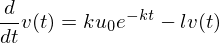

In [11]:
eqs[1].subs({funcs[0]: solutions[0]})

## Integrating factor
The kind of differential equation above may be solved using an integrating factor.
For an equation of type:

$ y' + P(t)y = Q(t) $

using an <a href=http://en.wikipedia.org/wiki/Integrating_factor>integrating factor</a>, M:

$ M = e^{\int_{0}^t P(s)ds} $

we have:

$ y = \frac{\int_0^t{MQ}}{M} + \frac{y(0)}{M} $

Identifying these terms in our differential equation for $v(t)$ leads to the following expressions:

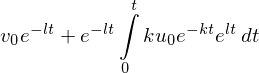

In [12]:
M = exp(l*t)
Q = k*solutions[0]
v_integral = Integral(M*Q, (t, 0, t))/M + inits[1]/M
v_integral

we can see that the expression for $y$ depends on whether $ k = l $ or  $ k \neq l $, this is important as we will see quite soon. First let's solve the integral by hand for $k \neq l$

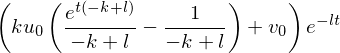

In [13]:
# for k != l, with pen and paper we integrate:
trial_neq = exp(-l*t)*(inits[1]+k*inits[0]*(exp(t*(l-k))/(l-k) - 1/(l-k)))
trial_neq

In [14]:
check_trial([solutions[0], trial_neq])[:2]

[True, True]

In [15]:
check_init([solutions[0], trial_neq])

[True, True]

Alright, `trial_neq` is a valid solution (`True` tells us with didn't mess up when doing this with pen and paper). 

Now let's do the same for the (simpler) case $k = l$:

In [16]:
# for k == l, with pen and paper we integrate:
trial_eq = exp(-l*t)*(inits[1]+k*inits[0]*t)
trial_eq

For checking the case of $l=k$ we need to substitute $l$ with $k$ (or vise versa), the second input argument in our convenience function was added just for this reason:

In [17]:
check_trial([solutions[0], trial_eq], {l: k})[:2], check_init([solutions[0], trial_eq])

([True, True], [True, True])

No surprises there: `trial_eq` is also a valid solution. We have now verified that our manual labour was done correctly. Next step is integrating $w$, we already realize that its closed form depends on wether $k = l$ holds, and we might (correctly) suspect that the same question will arise for $l = m$. We will in the following assume that $ k \neq l $, $ l \neq m $ and $ k \neq m $. This is is also an interesting case which has a general solution found by Bateman, which we will look closer at soon.

We found the integrals for our trial function by hand. We will now look into how we could have made SymPy do this for us.

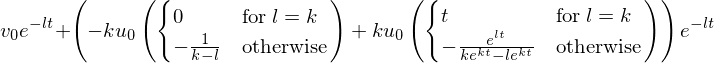

In [18]:
vsol = v_integral.doit()
vsol

 SymPy correctly identifies the two solutions, now let's tell SymPy that we are interested in the solution for $k \neq l$.

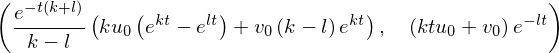

In [19]:
eq_assumption = sympy.Q.is_true(Eq(l, k))
vsol_eq = refine(vsol, eq_assumption).simplify()
vsol_neq = refine(vsol, ~eq_assumption).simplify()
solutions[1] = vsol_eq
vsol_neq, vsol_eq

Let us see if that is the same result as we got by hand:

In [20]:
(trial_neq - vsol_neq).simplify()

Indeed it is.

Ok, now let's see if we can put all our steps for solving $v(t)$ into an algorithm and apply it for $w(t)$:

In [21]:
def integrate_using_integrating_factor(idx, **kwargs):
    # Note that this functions uses some global state (which is sub-optimal):
    #   inits, params, solutions, t
    M = exp(params[idx]*t)
    Q = params[idx-1]*solutions[idx-1]
    y_int = Integral(M*Q, (t, 0, t)).doit(**kwargs)/M + inits[idx]/M
    assumptions = None
    for idx2 in range(idx-1,-1,-1):
        # k != l != m != ...
        if assumptions == None:
            assumptions = ~sympy.Q.is_true(Eq(params[idx], params[idx2]))
        else:
            assumptions = assumptions & ~sympy.Q.is_true(Eq(params[idx], params[idx2]))
    return refine(y_int, assumptions)

Let's test this function it for $v(t)$:

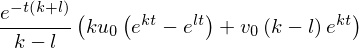

In [22]:
integrate_using_integrating_factor(1).simplify()

It turns out that the integration takes a very long time if we try to use this for $w(t)$,
so let's see if we can help sympy by giving it a hint. We will use $v(t)$ as a benchmark

1 loop, best of 3: 217 ms per loop


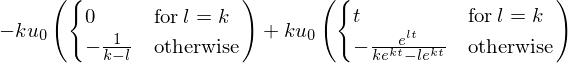

In [24]:
v_int_part = Integral(M*Q, (t, 0, t))
%timeit v_int_part.doit()
v_int_part.doit()

The <a href="http://docs.sympy.org/0.7.6/modules/integrals/integrals.html">sympy documentation</a> tells us to look at the
docstring of <a href="https://github.com/sympy/sympy/blob/sympy-0.7.6/sympy/integrals/integrals.py#L628">sympy.Integral._eval_integral</a>. From there we learn that one
algortihm "Meijerg" is supposed to be efficient for definite integrals so we give it a try:

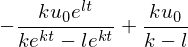

In [25]:
v_int_part.doit(meijerg=True)

Note that ``meijerg=True`` caused sympy to miss the special case of $k=l$

Now let's see how fast it is:

In [26]:
%timeit v_int_part.doit(meijerg=True)

10 loops, best of 3: 67.4 ms per loop


More than twice as fast, let's try it for $w$

integration took 1.8 seconds.


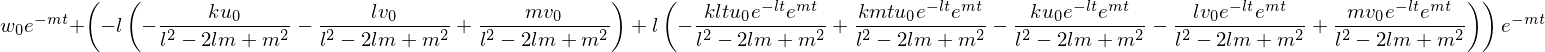

In [27]:
import time
time0 = time.time()
solutions[2] = integrate_using_integrating_factor(2, meijerg=True)  # Not passing meijerg = True takes too long..
print("integration took %3.1f seconds." % (time.time()-time0))
solutions[2]

We can try for $x(t)$ as well, it takes about 30s on my laptop:

integration took 773.5 seconds.


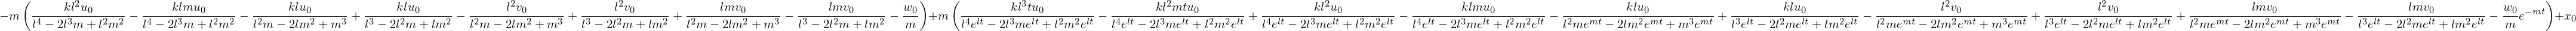

In [28]:
import time
time0 = time.time()
solutions[3] = integrate_using_integrating_factor(3, meijerg=True)
print("integration took %3.1f seconds." % (time.time()-time0))
solutions[3]

Ok, now the assumptions are getting tricky (or rather, SymPy's way to handle them here makes life hard for us). Let us therefore abandon this approach for a little while and look at <a href="http://en.wikipedia.org/wiki/Bateman_Equation">the Bateman Equation</a>. 

## Bateman Equation
In his <a href="https://archive.org/details/cbarchive_122715_solutionofasystemofdifferentia1843">paper from 1910</a> Bateman solves the system of differential equations
by first taking the <a href="http://en.wikipedia.org/wiki/Laplace_transform">Laplace transform</a> of the dependent variables (for u: $U(t) = \int_0^\infty e^{-ts}u(s)ds$). For the case of no source terms, and where there are no daughters at $t=0$ the solution is (indexing starts at 0):

$$
N_i = N_0(0) \left(
   \prod_{j=0}^{i-1} \lambda_j
  \right)
  \sum_{k=0}^{i} \frac{
   e^{-\lambda_k t}
  }{
   \prod_{l=0,l\neq k}^{i} \lambda_l - \lambda_k
  }
$$

Let us impement that equation as `bateman_parent()` indicating it is valid for a system starting with no daughters:

In [29]:
def bateman_parent(lmbd, t, one=1, zero=0, exp=None):
    n = len(lmbd)
    N = [None]*n
    lmbd_prod = one
    if exp == None:
        import math
        exp = math.exp
    for i in range(n):
        if i > 0:
            lmbd_prod *= lmbd[i-1]
        sum_k = zero
        for k in range(i+1):
            prod_l = one
            for l in range(i+1):
                if l == k:
                    continue
                prod_l *= lmbd[l] - lmbd[k]
            sum_k += exp(-lmbd[k]*t)/prod_l
        N[i] = lmbd_prod*sum_k
    return N

For a single decay with unit initial number density we get:

In [30]:
[expr.simplify() for expr in bateman_parent([k, S('0')], t, S('1'), S('0'), sympy.exp)]

So that looks promising, let's write a wrapping function `bateman_full()` for the general solution with possibly finite initial daughter concentrations. One may quickly realize that the expression must be a linear combination of (shorter) decay chains where the indiviual chains represent systems with no daughters:

In [31]:
def bateman_full(y0s, lmbd, t, one=1, zero=0, exp=None):
    n = len(lmbd)
    if len(y0s) != n:
        raise ValueError("Please pass equal number of decay"
                         " constants as initial concentrations"
                         " (you may want to pad lmbd with zeroes)")
    N = [zero]*n
    for i, y0 in enumerate(y0s):
        if y0 == zero:
            continue
        Ni = bateman_parent(lmbd[i:], t, one, zero, exp)
        for j, yj in enumerate(Ni, i):
            N[j] += y0*yj
    return N

Applying ``bateman_full(...)`` on our initial problem gives us the following solutions:

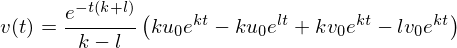

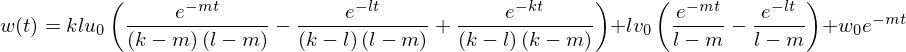

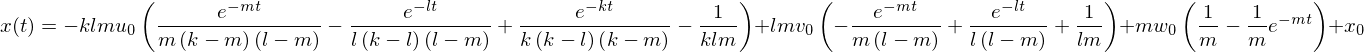

In [32]:
bsol = [expr.simplify() for expr in bateman_full(inits, params, t, S('1'), S('0'), sympy.exp)]
for func, bs in zip(funcs, bsol):
    display(Eq(func, bs))

We note that the equations assume $k>0, l>0, m>0$ and all unique.

Let's verify that the solutions satisify our differential equations and our initial value problem:

In [33]:
check_trial(bsol), check_init(bsol)

([True, True, True, True], [True, True, True, True])

Let's plot the solutions, first we need some fast callbacks which we generate with the SymPy function ``lambdify``:

In [34]:
callbacks = [lambdify((t, params[:-1], inits), bs) for bs in bsol]

Let's assert that the callback for $u(t)$ is calculating the correct answer for k=1, t=1.0, u0=3.0:

In [35]:
callbacks[0](1.0, [1, 2, 3], [3, 2, 1, 0]), sympy.N(3*exp(-1), 12)

Let's define some convenience functions for calculating arrays of solutions and plotting those:

In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def solution_vectors(t0=0, tend=4, nt=100, param_vals=None, init_vals=None, modules=None):
    callbacks = [lambdify((t, params[:-1], inits), bs, modules) for bs in bsol]
    tarr_ = np.linspace(t0, tend, nt)
    params_ = param_vals or (1, 2, 3)
    inits_ = init_vals or (3, 2, 1, 0)
    ysols_ = [[cb(t_, params_, inits_) for t_ in tarr_] for cb in callbacks]
    return tarr_, np.asarray(ysols_)

def plot_solutions(t_vals, y_vals):
    plt.figure(figsize=(8,5))
    for idx, ysol_ in enumerate(y_vals):
        plt.plot(t_vals, ysol_, label='$%s$' % latex(funcs[idx]))
    plt.xlabel('t')
    plt.ylabel('N')
    plt.legend(loc='best', prop={'size': 16})

And let's put those helper functions to work:

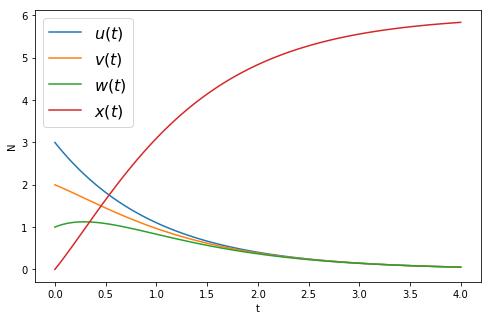

In [37]:
t_vals, y_vals = solution_vectors()
plot_solutions(t_vals, y_vals)

So, this look great. Bateman's equation does however exhibit one unpleasent feature when implemented in
algortihms using finite precision floating point arithmetics: if the decay constants are almost equal
catastrophic cancellation may occur which induce major loss in precision ([double precision](https://en.wikipedia.org/wiki/Double-precision_floating-point_format) numbers are 64 bit long). Let's see what that might look like:

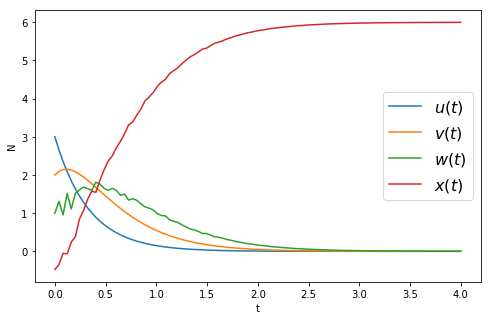

In [38]:
double_precision = solution_vectors(param_vals=(3, 3-1e-7, 3+1e-7))
plot_solutions(double_precision[0], double_precision[1])

We see noise in the solution curves stemming from cancellation. SymPy can use arbitrary precision arithmetics, we will now look at how that affects the solution trajectories. First let's see if we can use "sympy" as the module for `lambdify`:

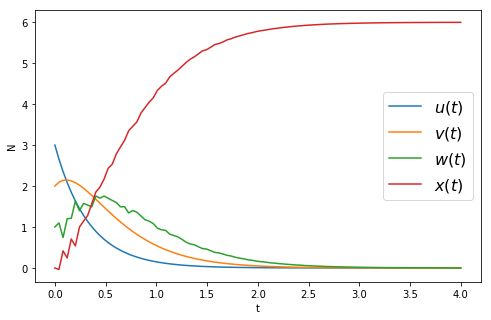

In [39]:
multi_precision = solution_vectors(modules='sympy', param_vals=(S(3), 3-S('10**-7'), 3+S('10**-7')))
plot_solutions(multi_precision[0], multi_precision[1])

No luck there, there seems as if there is an implicit conversion to double precision somewhere(?), we try to go the extra mile and write our own callbacks without using lambdify:

In [40]:
def callback_factory(bs):
    def callback(t_, params_, inits_):
        return bs.subs(dict([(t, t_)] + list(zip(params[:-1], params_)) + list(
                zip(inits, inits_))))
    return callback
    
def calc_solutions_mp(t0=0, tend=4, nt=100, param_vals=None, init_vals=None, modules=None):
    callbacks = []
    for bs in bsol:
        callbacks.append(callback_factory(bs))
    tarr_ = [t0 + i*(tend-t0)/S(nt-1) for i in range(nt)]
    params_ = param_vals or (1, 2, 3)
    inits_ = init_vals or (3, 2, 1, 0)
    ysols_ = [[cb(t_, params_, inits_) for t_ in tarr_] for cb in callbacks]
    return tarr_, np.asarray(ysols_)


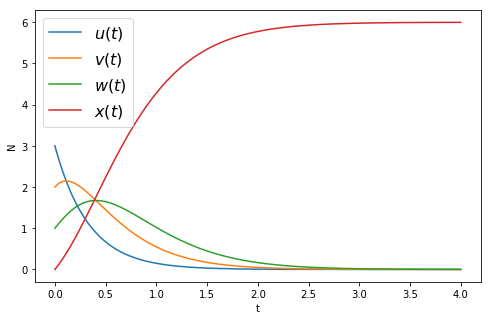

In [41]:
multi_precision = calc_solutions_mp(param_vals=(S(3), 3-S('10**-7'), 3+S('10**-7')))

plot_solutions(multi_precision[0], multi_precision[1])

Success!

The generation of solution above is significantly slower due to the extra overhead of arbitrary precision arithmetics.

Another remedy to the problem is to integrate the system of ordinary differential equations numerically using an [ODE solver](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations). But that is a whole topic in its own right and this is about as much as I aspired to show in this notebook. 

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" href="http://purl.org/dc/dcmitype/InteractiveResource" property="dct:title" rel="dct:type">Linear decay chains and the Bateman equation</span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Björn I. Dahlgren</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.